# MH proposals for discrete Potts models

This notebook performs experiments with MCMC samplers from [Grathwohl et al. (2021)](https://arxiv.org/abs/2102.04509), [Zanella (2017)](https://arxiv.org/abs/1711.07424), and [Zhang et al. (2022)](https://arxiv.org/abs/2206.09914).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math
from collections import Counter, defaultdict
from typing import Callable, Dict, Iterable, Iterator, List, Optional, Tuple

import numpy as np
import torch
import torch.distributions as dist
import pyro
import matplotlib
import matplotlib.pyplot as plt
from torch.distributions import constraints
from opt_einsum import contract as einsum
from pyro.ops.stats import autocorrelation
from pyro.ops.tensor_utils import convolve
from tqdm.auto import tqdm

matplotlib.rcParams.update({'figure.facecolor': "white"})
matplotlib.rcParams.update({'figure.dpi': 200})

Let's compare two of Zanella's balancing functions `g(-)`.

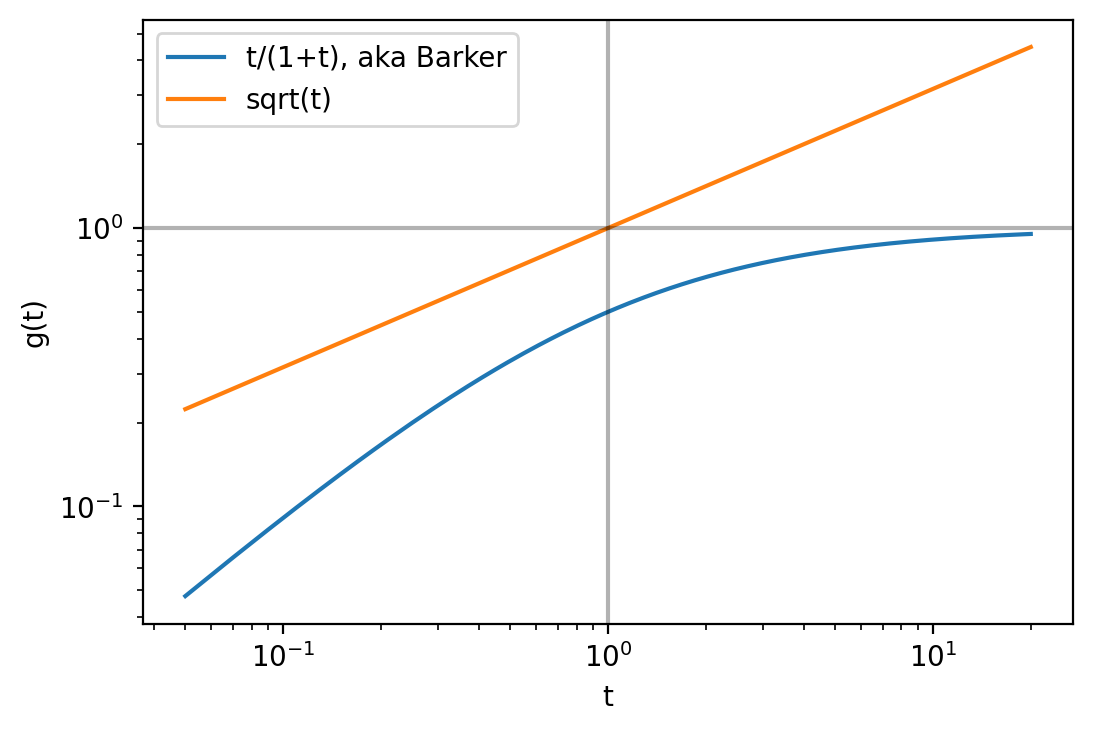

In [3]:
t = np.linspace(0.05,20,1000)
plt.plot(t, t / (1 + t), label="t/(1+t), aka Barker")
plt.plot(t, t ** 0.5, label="sqrt(t)")
plt.xlabel("t")
plt.ylabel("g(t)")
plt.xscale("log")
plt.yscale("log")
plt.axvline(1, color="black", alpha=0.3)
plt.axhline(0, color="black", alpha=0.3)
plt.axhline(1, color="black", alpha=0.3)
plt.legend(loc="best");

Note that in log space where $x=\log(t)$, Barker's function becomes PyTorch's `logsigmoid` function:
$$
\log\circ(t\mapsto\frac t{1+t})\circ\exp = x\mapsto\log(\operatorname{sigmoid}(x))
$$
Similarly in log space, the sqrt function becomes
$$
  \log]\circ(t\mapsto\sqrt t)\circ\exp = x\mapsto x/2
$$

In [4]:
def balance_sqrt(logt):
    return logt / 2

def balance_barker(logt):
    return torch.nn.functional.logsigmoid(logt)

def balance_global(logt):
    return logt

Next consider a sparse Potts distribution class, where we implement a `.log_prob_nbhd()` method for locally-informed Metropolis-Hastings sampling.

In [38]:
class OneHotCategoricalPotts(dist.Distribution):
    arg_constraints = {
        "vertex_weights": constraints.independent(constraints.real, 2),
        "edge_weights": constraints.independent(constraints.real, 3),
    }
    support = constraints.independent(constraints.one_hot, 1)

    def __init__(
        self, vertex_weights: torch.Tensor, edge_weights: torch.Tensor, edges: torch.Tensor
    ):
        self.vertex_weights = vertex_weights
        self.edge_weights = edge_weights
        self.edges = edges
        assert edges.dim() == 2
        assert edges.shape[0] == 2
        assert all(len(set(edge)) == 2 for edge in edges.T.tolist()), "self edge"
        super().__init__(batch_shape=(), event_shape=vertex_weights.shape)

    def log_prob(self, x_onehot: torch.Tensor) -> torch.Tensor:
        """Returns non-normalized lob_prob."""
        if self._validate_args:
            assert x_onehot.dim() >= 2
            self._validate_sample(x_onehot)
        head, tail = x_onehot[..., self.edges, :]
        return (
            einsum("...vk,vk->...", x_onehot, self.vertex_weights)
            + einsum("...ej,...ek,ejk->...", head, tail, self.edge_weights)
        )

    def log_prob_nbhd(self, x_onehot: torch.Tensor) -> Tuple[float, torch.tensor]:
        """Assuming there are no self-edges (as asserted above),
        the gradient approximation of Grathwohl et al. (2021) is exact.
        """
        x_grad = x_onehot.clone().requires_grad_()
        log_prob = self.log_prob(x_grad)
        nbhd = torch.autograd.grad(log_prob, x_grad)[0].detach()
        nbhd -= (nbhd * x_onehot).sum(-1, True)
        nbhd.clamp_(max=20)  # numerically stabilize
        assert not nbhd.requires_grad
        return log_prob.detach().item(), nbhd
    
    def enumerate_support(self):
        p, k = self.event_shape
        result = torch.zeros(k ** p, p, k)
        ks = [list(range(k))] * p
        for a, cs in enumerate(itertools.product(*ks)):
            for b, c in enumerate(cs):
                result[a, b, c] = 1
        return result

In [6]:
def random_potts(p: int=100, k: int=20, density: float=0.1, temperature: float=2):
    P = torch.arange(p)
    e = p * (p - 1) // 2
    complete_edges = torch.stack([
        P[:, None].expand(p, p), P.expand(p, p)
    ], 0).reshape(2, p * p)
    complete_edges = complete_edges[:, complete_edges[0] < complete_edges[1]]
    assert complete_edges.shape == (2, e)
    complete_edges = complete_edges[:, torch.randperm(e)]
    edges = complete_edges[:, :round(density * e)].clone()
    vertex_weights = torch.randn(p, k) / temperature
    edge_weights = torch.randn(edges.shape[1], k, k) / temperature
    return OneHotCategoricalPotts(vertex_weights, edge_weights, edges)

In [7]:
def test_enumerate_support(p, k, expected):
    actual = random_potts(p, k).enumerate_support().tolist()
    assert actual == expected
    
test_enumerate_support(
    2, 2,
    [
        [[1, 0], [1, 0]],
        [[1, 0], [0, 1]],
        [[0, 1], [1, 0]],
        [[0, 1], [0, 1]],
    ],
)
    
test_enumerate_support(
    2, 3,
    [
        [[1, 0, 0], [1, 0, 0]],
        [[1, 0, 0], [0, 1, 0]],
        [[1, 0, 0], [0, 0, 1]],
        [[0, 1, 0], [1, 0, 0]],
        [[0, 1, 0], [0, 1, 0]],
        [[0, 1, 0], [0, 0, 1]],
        [[0, 0, 1], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
        [[0, 0, 1], [0, 0, 1]],
    ],
)

In [8]:
def gibbs_with_gradients(
    d: OneHotCategoricalPotts, g: callable
) -> Iterator[Tuple[torch.Tensor, int]]:
    # Initialize to random uniform.
    p, k = d.event_shape
    x0 = torch.zeros(p, k)
    x0[torch.arange(p), torch.randint(0, k - 1, (p,))] = 1
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = g(nbhd)
    logq0 -= logq0.reshape(-1).logsumexp(0)  # normalize

    while True:
        # Propose.
        ij = dist.Categorical(logits=logq0.reshape(-1)).sample().item()
        i, j1 = divmod(ij, k)
        x1 = x0.clone()
        x1[i] = 0
        x1[i, j1] = 1
        j0 = int(x0[i].max(0).indices)
        if j1 == j0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = g(nbhd)
        logq1 -= logq1.reshape(-1).logsumexp(0)  # normalize
        ratio = (logp1 - logp0 + logq1[i, j0] - logq0[i, j1]).exp()
        accept = int(ratio > torch.rand(()))
        if accept:
            x0, logp0, logq0 = x1, logp1, logq1
        yield x0, accept

In [9]:
def discrete_langevin(
    d: OneHotCategoricalPotts, g: callable, stepsize:float = 1.0
) -> Iterator[Tuple[torch.Tensor, int]]:
    """
    Implements Metropolis-Hastings with discrete Langevin proposals
    from Zhang et al. (2022) https://arxiv.org/abs/2206.09914.
    """
    # Initialize to random uniform.
    x0 = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = g(nbhd)
    logq0 += x0 / stepsize
    logq0 -= logq0.logsumexp(-1, True)  # normalize

    while True:
        # Propose.
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = g(nbhd)
        logq1 += x1 / stepsize
        logq1 -= logq1.logsumexp(-1, True)  # normalize
        ratio = (logp1 - logp0 + torch.tensordot(logq1, x0) - torch.tensordot(logq0, x1)).exp()
        if ratio > torch.rand(()):
            x0, logp0, logq0 = x1, logp1, logq1
        else:
            distance = 0
        yield x0, distance

In [10]:
def adaptive_langevin(
    d: OneHotCategoricalPotts, g: callable,
) -> Iterator[Tuple[torch.Tensor, int]]:
    def make_logq(x, nbhd):
        logq = g(nbhd)
        # Set step size so that q(x1[i] = x0[i]) > 1/2 for every i.
        logq += x * logq.exp().sum(-1).max().sub(1).clamp(min=1).log()
        logq -= logq.logsumexp(-1, True)  # normalize
        return logq
        
    # Initialize to random uniform.
    x0 = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = make_logq(x0, nbhd)

    while True:
        # Propose.
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = make_logq(x1, nbhd)
        ratio = (logp1 - logp0 + torch.tensordot(logq1, x0) - torch.tensordot(logq0, x1)).exp()
        if ratio > torch.rand(()):
            x0, logp0, logq0 = x1, logp1, logq1
        else:
            distance = 0
        yield x0, distance

In [11]:
def unadjusted_langevin(d: OneHotCategoricalPotts, _) -> Iterator[Tuple[torch.Tensor, int]]:
    x = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    while True:
        logp, logq = d.log_prob_nbhd(x)
        x_old, x = x, dist.OneHotCategorical(logits=logq).sample()
        distance = round((x != x_old).sum().div(2).item())
        yield x, distance

## Testing the sampler

Let's quick test that the sampler draws correct samples.

In [12]:
def one_hot_to_hashable(x_onehot: torch.Tensor) -> Tuple[int]:
    assert x_onehot.dim() == 2
    assert (x_onehot.sum(-1) == 1).all()
    return tuple(x_onehot.max(-1).indices.tolist())

In [13]:
def get_histogram(n, d, g, mcmc):
    hist = Counter()
    distances = Counter()
    for i, (x, distance) in tqdm(enumerate(mcmc(d, g)), total=n):
        hist[one_hot_to_hashable(x)] += 1
        if i >= n:
            break
        distances[distance] += 1
    mean = sum(k * v for k, v in distances.items()) / sum(distances.values())
    print(f"mean distance = {mean:0.3f}")
    return hist

In [14]:
def sample_efficiency(counts: torch.Tensor, probs: torch.Tensor) -> float:
    assert counts.sum() > probs.sum()
    total = counts.sum()
    chisq = (counts - total * probs).square().sum().div(total)
    return float(1 / chisq)

In [15]:
print(sample_efficiency(torch.tensor([99, 101]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([90, 110]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([9900, 10100]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([80, 120]), torch.tensor([0.5, 0.5])))

100.0
1.0
1.0
0.25


In [16]:
def test_gof(mcmc, p, k, g=balance_sqrt, n=20000):
    pyro.set_rng_seed(20220709)
    d = random_potts(p, k, density=0.9)
    hist = get_histogram(n, d, g=g, mcmc=mcmc)
    xs = d.enumerate_support()
    log_probs = {one_hot_to_hashable(x): float(d.log_prob(x)) for x in xs}  # non-normalized
    log_total = float(torch.tensor(list(log_probs.values())).logsumexp(-1))
    probs_dict = {k: math.exp(v - log_total) for k, v in log_probs.items()}
    keys = sorted(probs_dict)
    probs = torch.tensor([probs_dict[k] for k in keys])
    probs, indices = probs.sort(0, descending=True)
    counts = torch.tensor([hist.pop(k, 0) for k in keys])[indices]
    assert not hist, f"invalid samples: {set(hist)}"
    eff = sample_efficiency(counts, probs)
    plt.figure(figsize=(6, 3))
    plt.plot(probs, "k--", label="truth")
    plt.plot(counts / counts.sum(), label="empirical")
    plt.ylabel("probability")
    plt.xlabel("rank")
    plt.legend(loc="best")
    plt.title(f"{mcmc.__name__}({g.__name__}) efficiency = {eff:0.4g}")

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.390


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.530


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.592


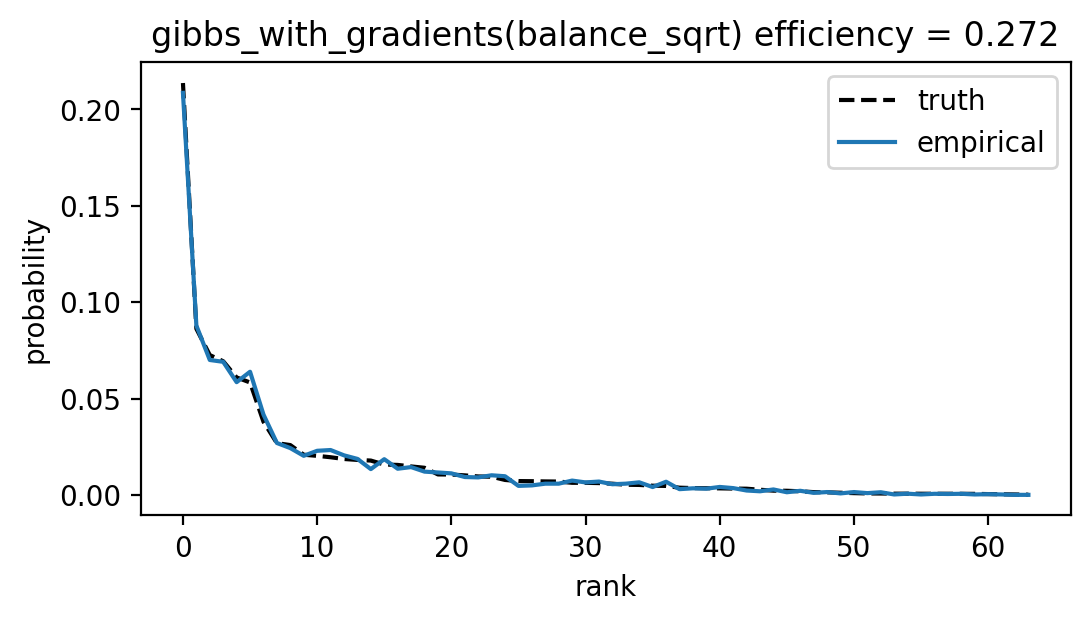

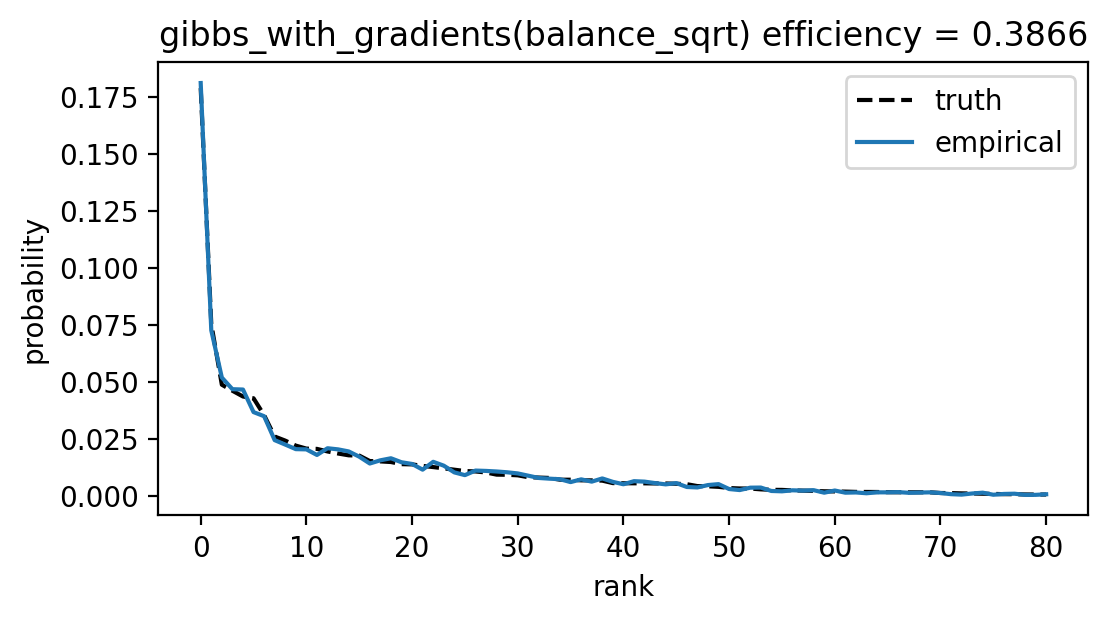

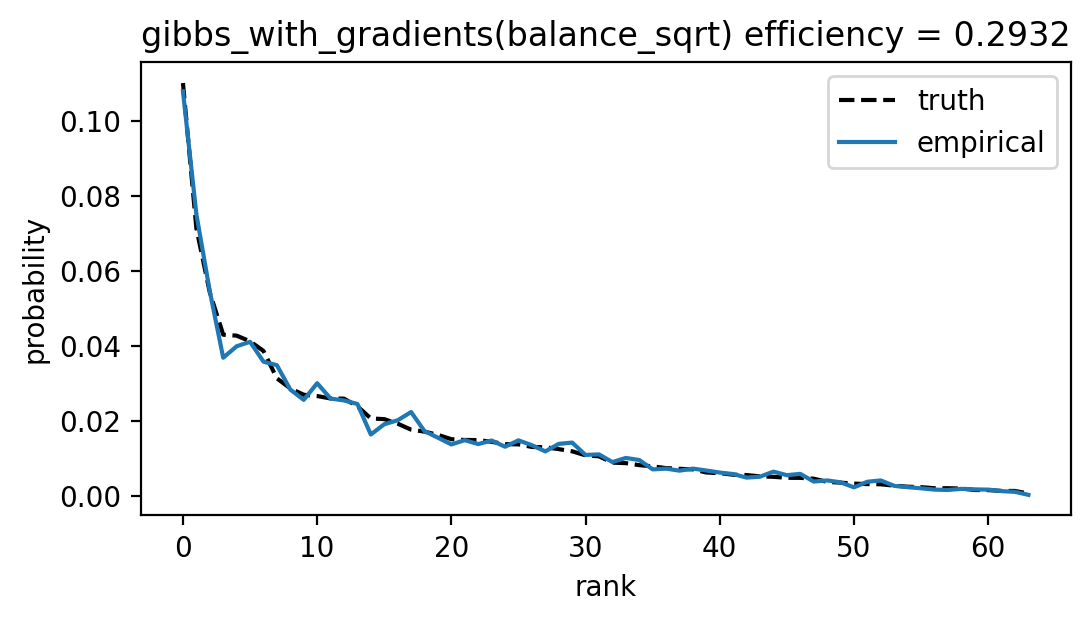

In [17]:
test_gof(gibbs_with_gradients, 6, 2)
test_gof(gibbs_with_gradients, 4, 3)
test_gof(gibbs_with_gradients, 3, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.889


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.974


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.934


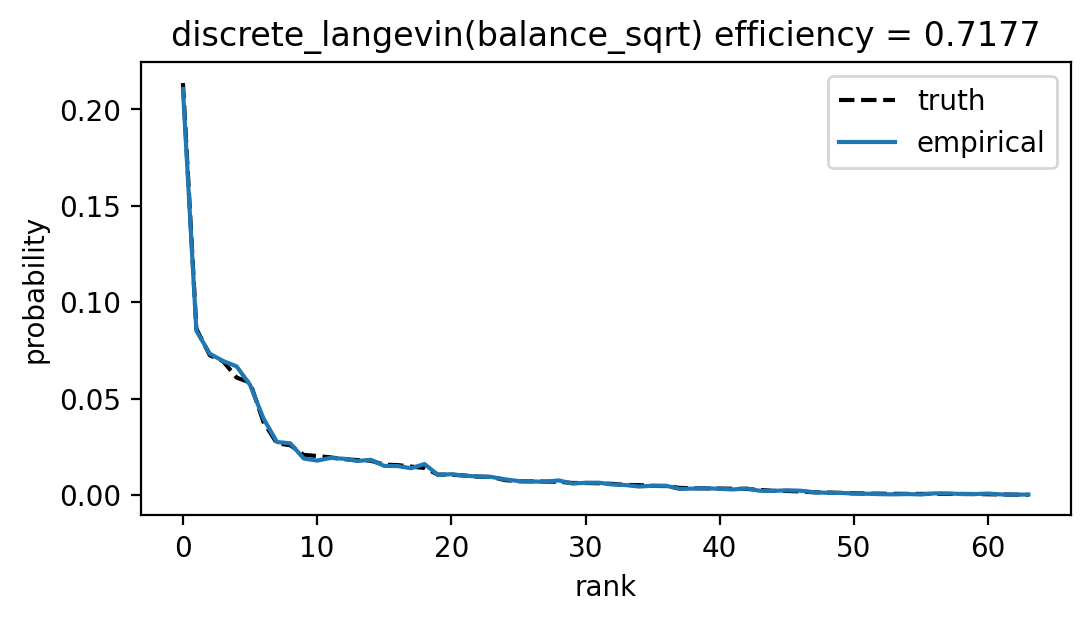

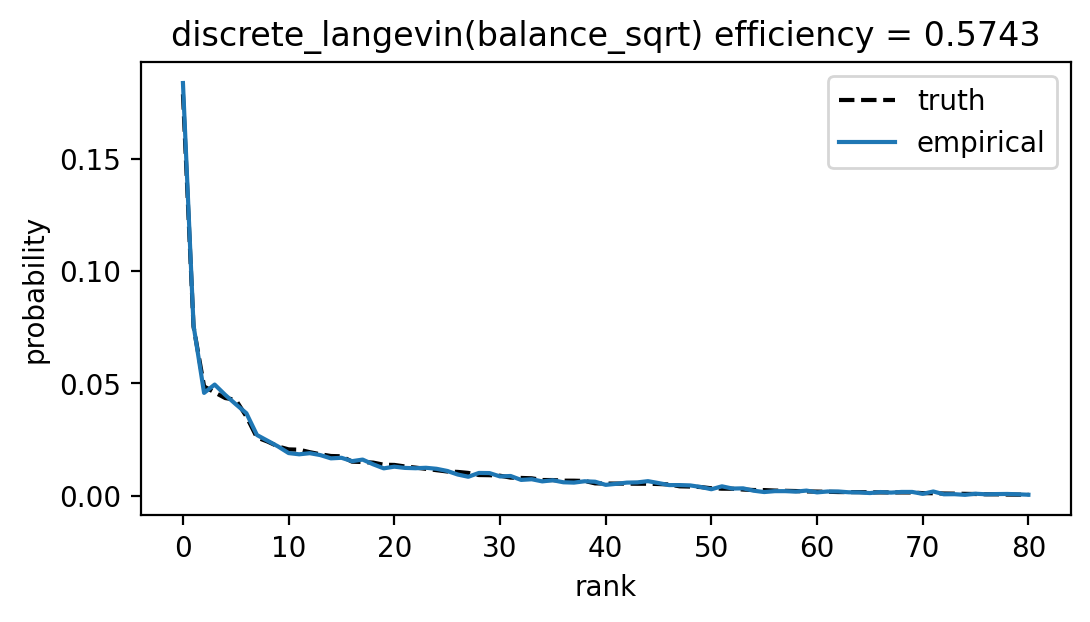

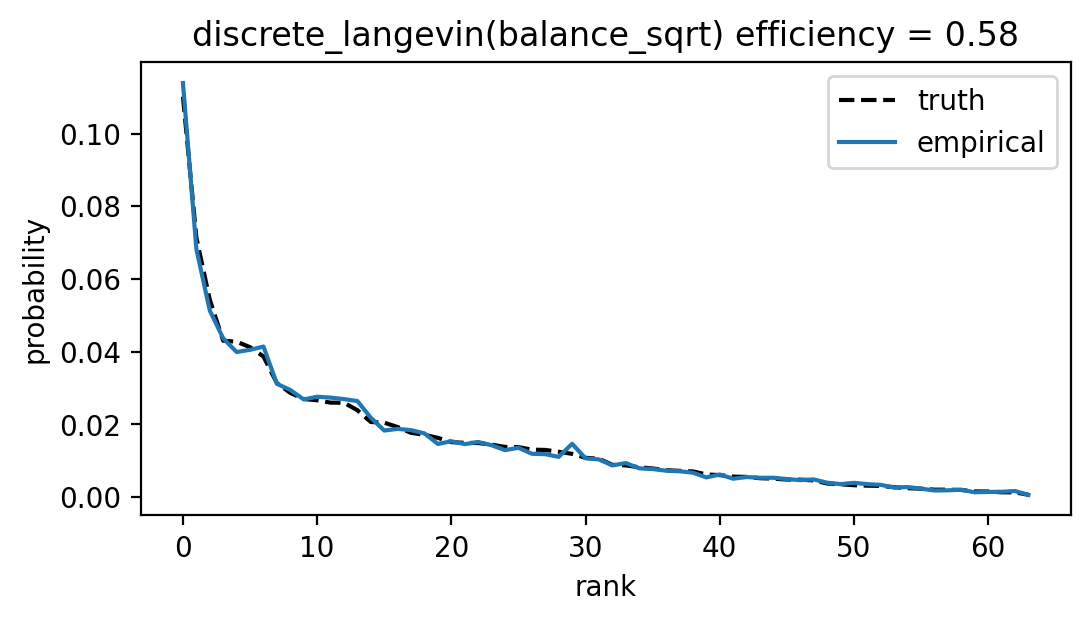

In [18]:
test_gof(discrete_langevin, 6, 2)
test_gof(discrete_langevin, 4, 3)
test_gof(discrete_langevin, 3, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.889


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.870


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.775


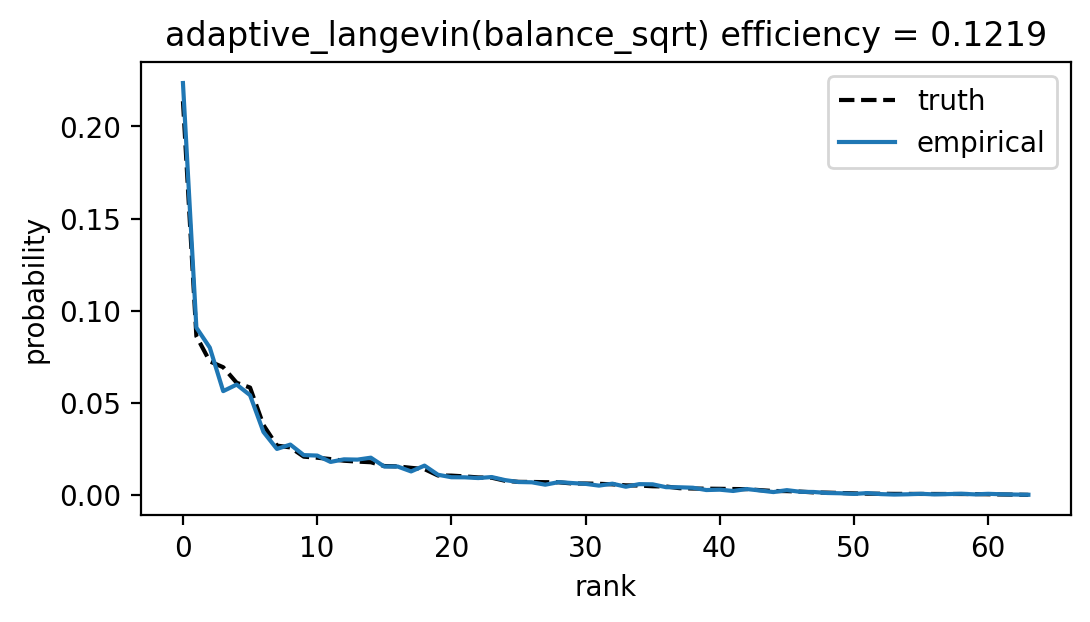

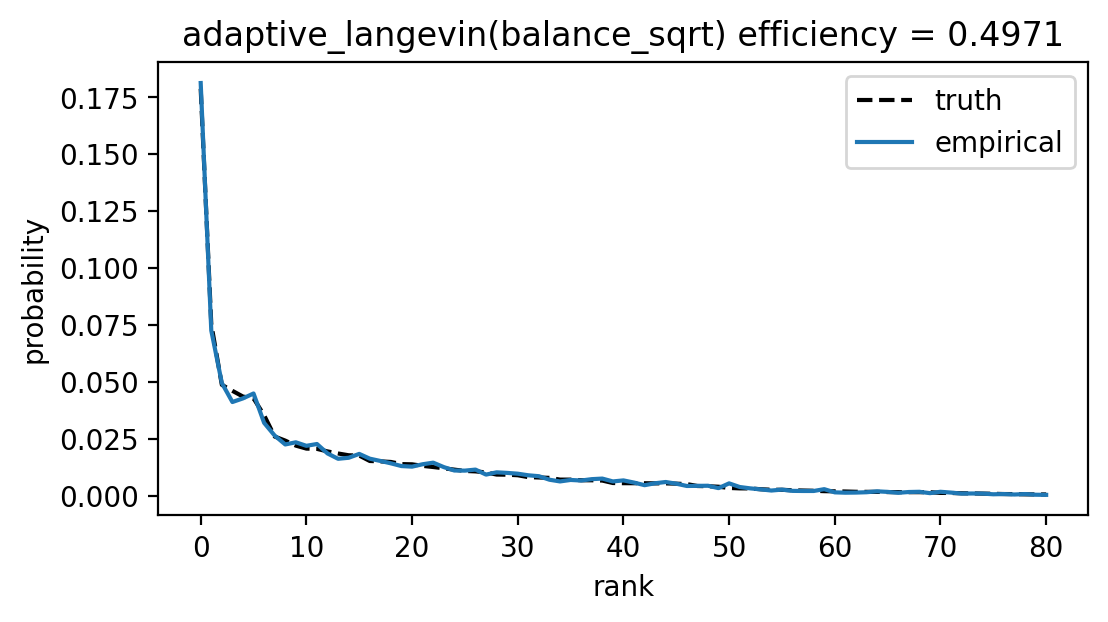

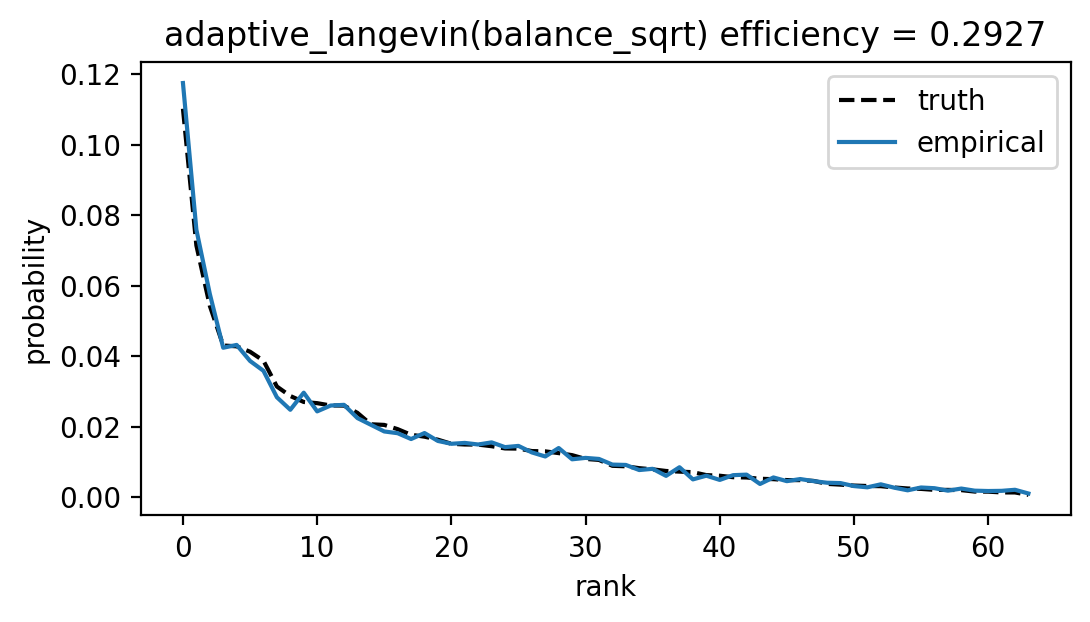

In [19]:
test_gof(adaptive_langevin, 6, 2)
test_gof(adaptive_langevin, 4, 3)
test_gof(adaptive_langevin, 3, 4)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.172


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.214


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 1.024


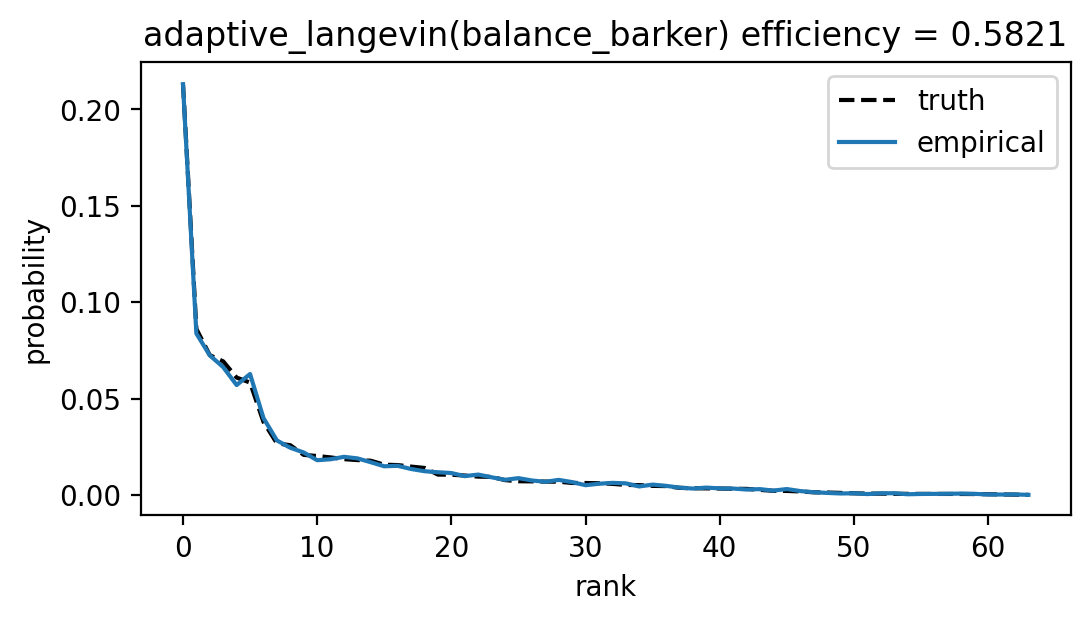

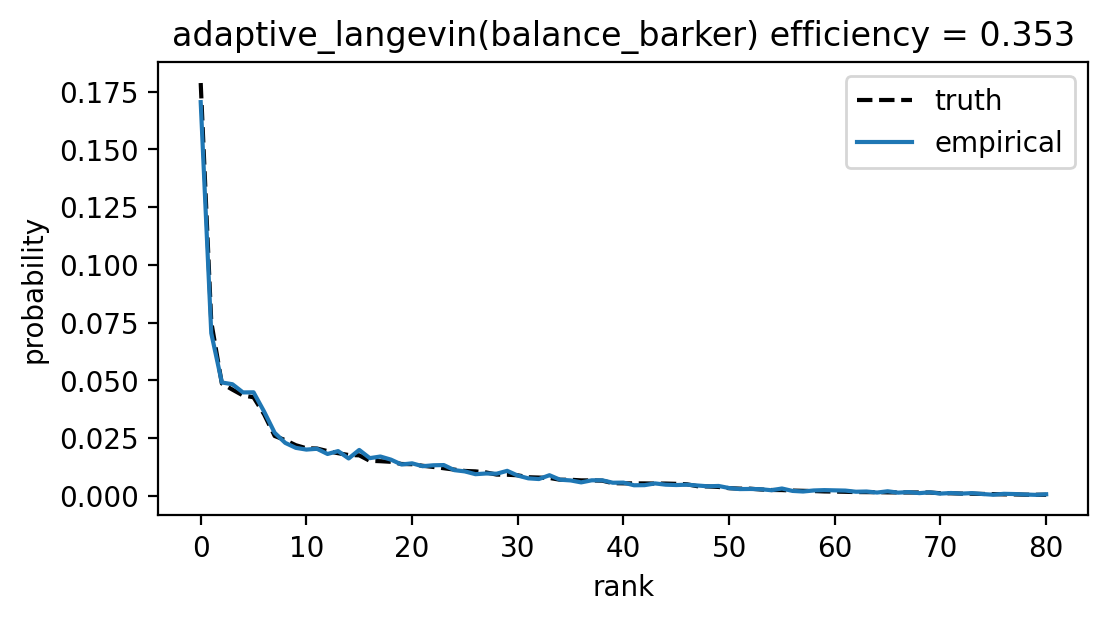

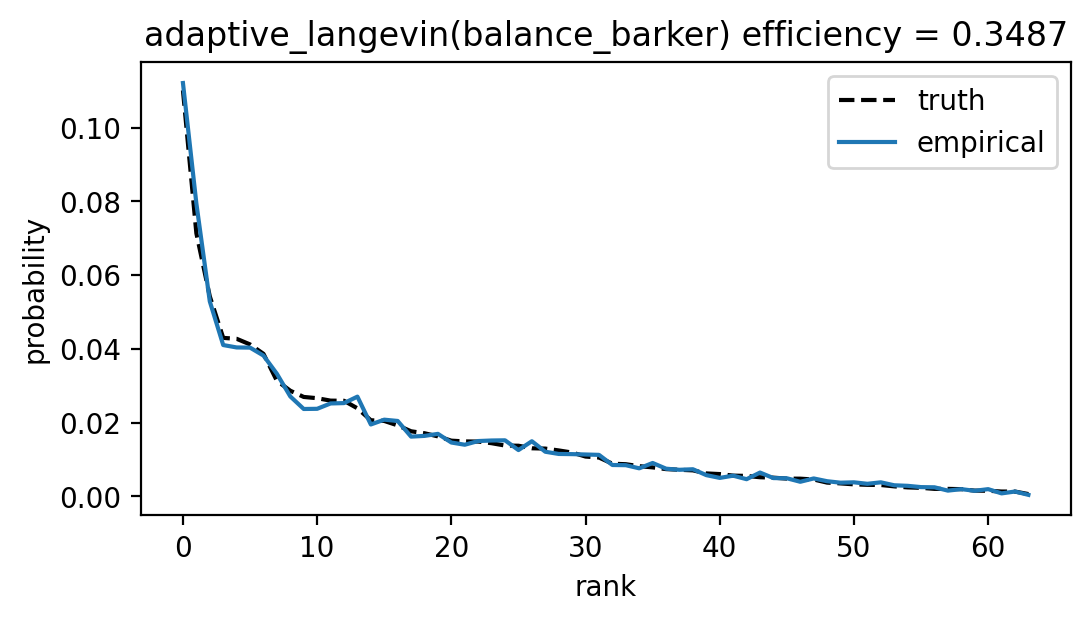

In [20]:
test_gof(adaptive_langevin, 6, 2, g=balance_barker)
test_gof(adaptive_langevin, 4, 3, g=balance_barker)
test_gof(adaptive_langevin, 3, 4, g=balance_barker)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.739


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.719


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 0.721


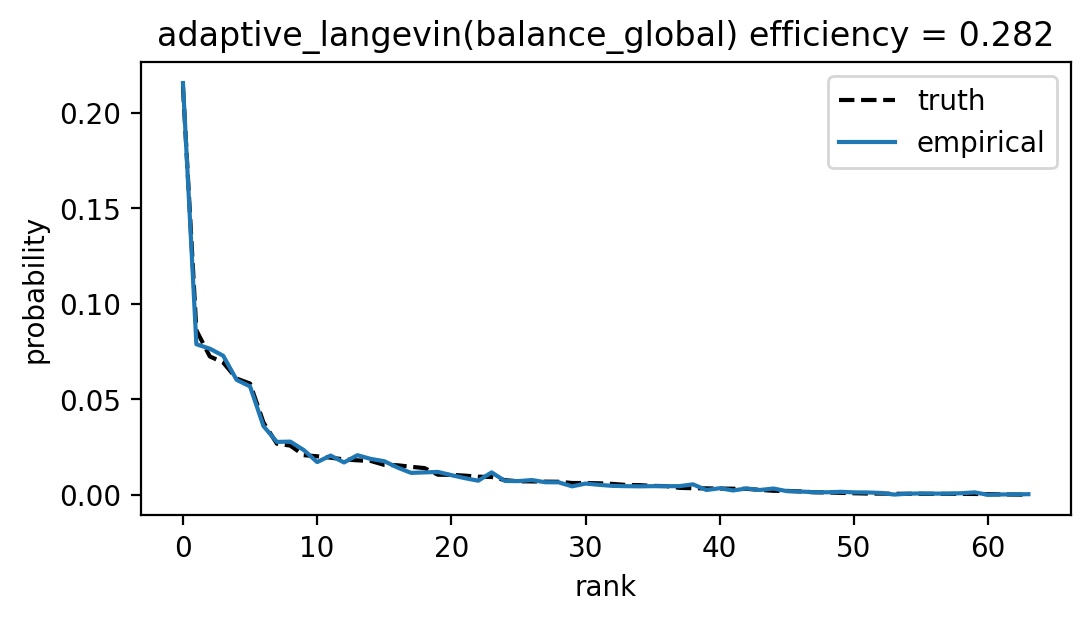

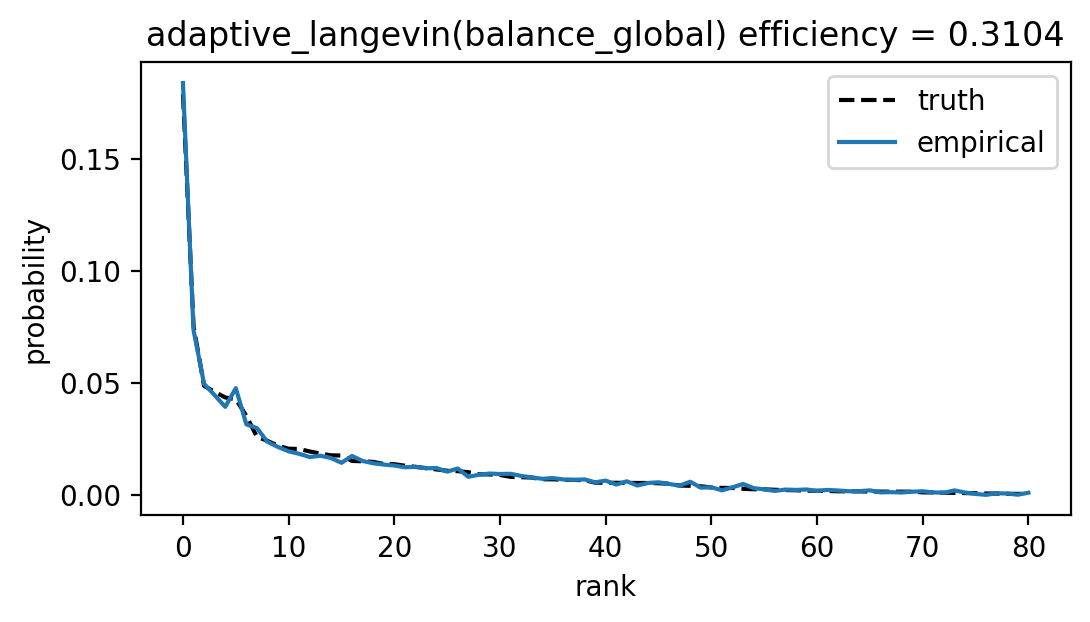

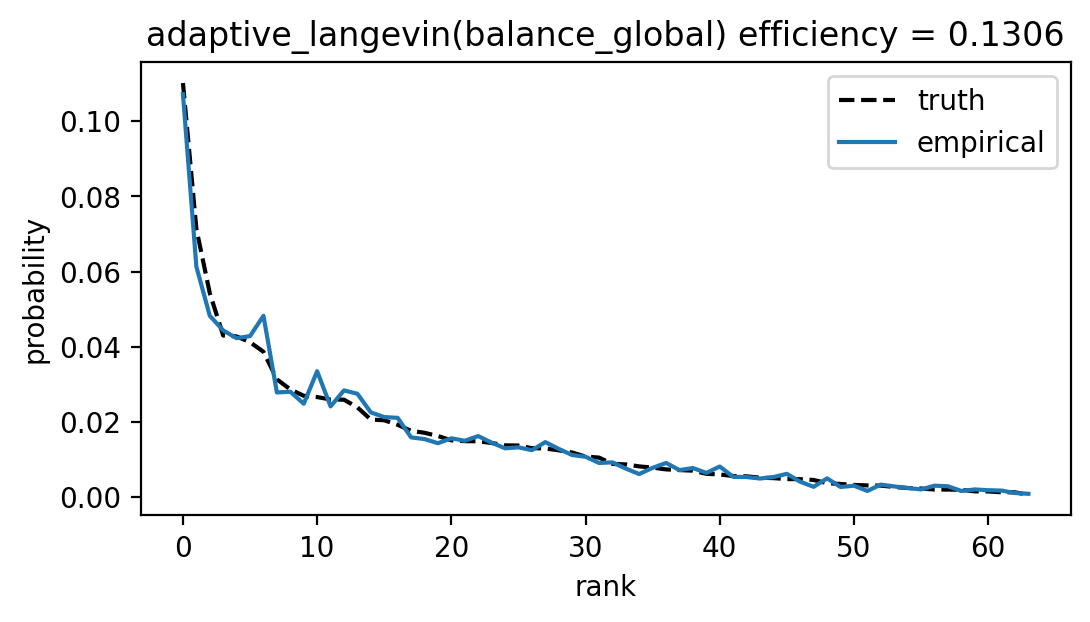

In [22]:
test_gof(adaptive_langevin, 6, 2, g=balance_global)
test_gof(adaptive_langevin, 4, 3, g=balance_global)
test_gof(adaptive_langevin, 3, 4, g=balance_global)

  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 2.292


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 2.270


  0%|          | 0/20000 [00:00<?, ?it/s]

mean distance = 2.127


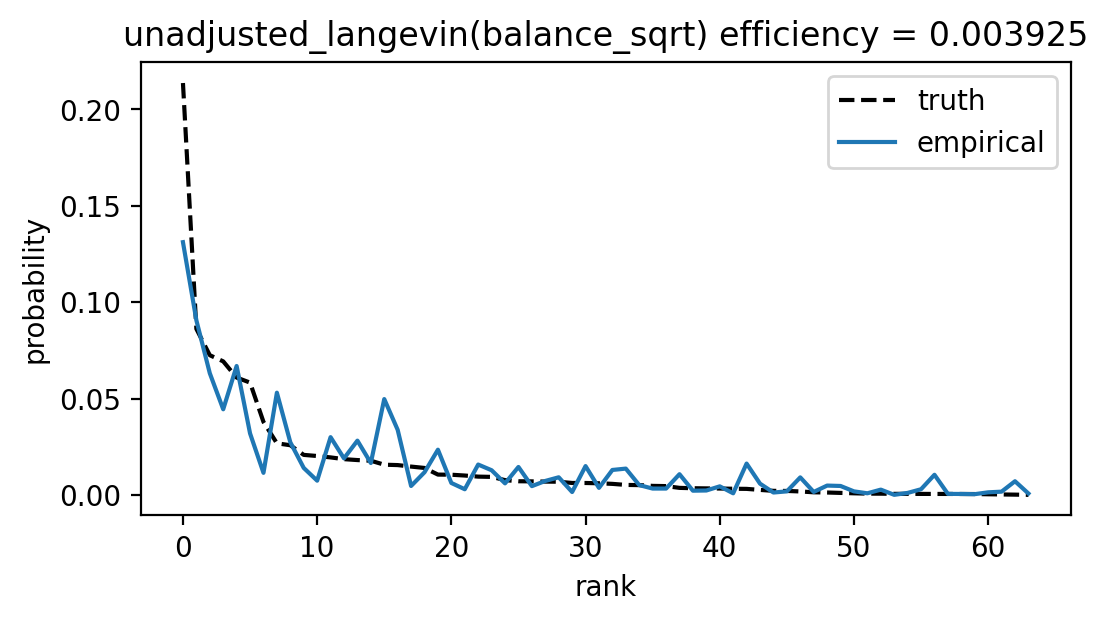

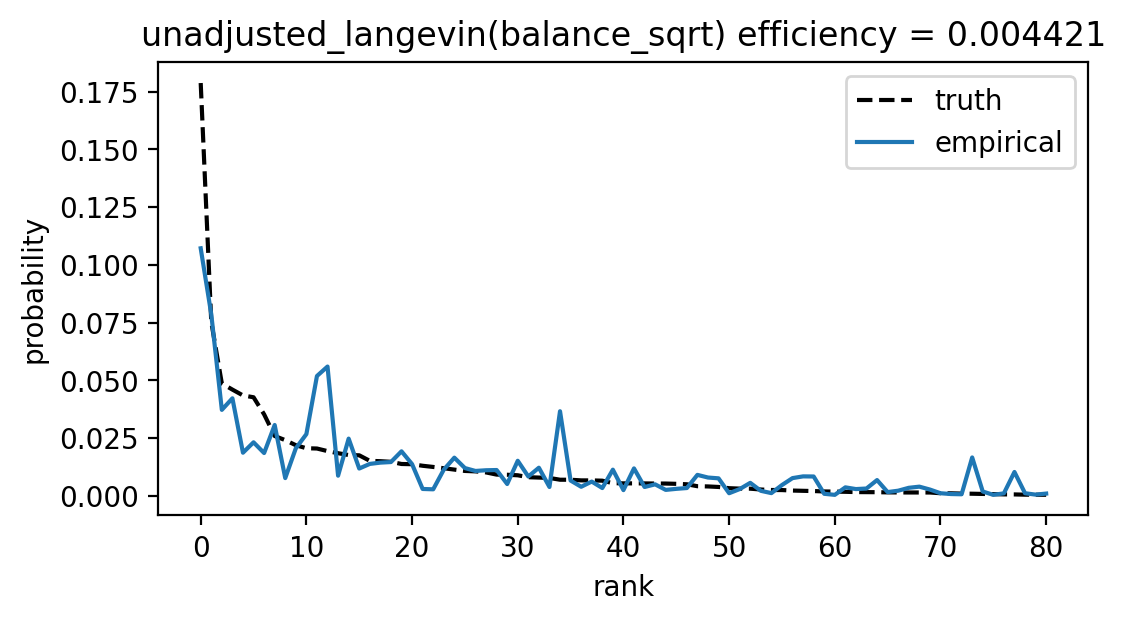

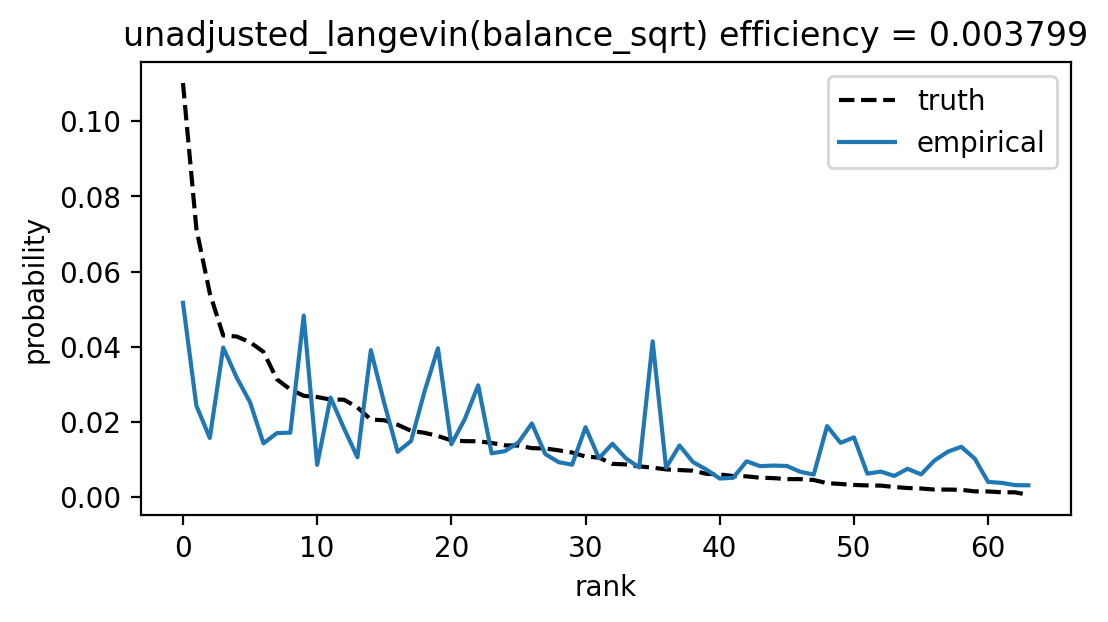

In [23]:
test_gof(unadjusted_langevin, 6, 2)
test_gof(unadjusted_langevin, 4, 3)
test_gof(unadjusted_langevin, 3, 4)

## Comparing balancing functions

In [24]:
def get_trace(p: int, k: int, n: int, g: callable, mcmc: callable, seed=20220708):
    pyro.set_rng_seed(seed)
    d = random_potts(p, k)
    xs = []
    distances = Counter()
    for i, (x, distance) in enumerate(mcmc(d, g)):
        xs.append(x)
        distances[distance] += 1
        if i >= n:
            break
    mean = sum(k * v for k, v in distances.items()) / sum(distances.values())
    print(f"mean distance = {mean:0.3f}")
    return torch.stack(xs)

In [25]:
def eff(a: torch.Tensor) -> float:
    """Computes sample efficiency from autocorrelation."""
    # https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html
    cutoff = 1 + 10 * a[:len(a) // 2].abs().gt(0.5).long().sum().item()
    a = a[1:cutoff]  # lag 1 up to cutoff
    return 1 / (1 + 2 * a.sum().item())

def plot_autocorrelation(p, k, s=20000):
    mcmcs = [
        ("Gibbs w/ Grads", gibbs_with_gradients, "g"),
        ("Langevin-stepsize-1", discrete_langevin, "b"),
        ("Langevin-adaptive", adaptive_langevin, "r"),
    ]
    gs = [
        ("sqrt", balance_sqrt, "--"),
        ("Barker", balance_barker, ":"),
        ("global", balance_global, "-"),
    ]
    plt.figure(figsize=(8, 5))
    plt.title(f"{p}-length sequences of {k}-sized alphabet")
    x = np.arange(1, 1 + s // 2)
    effs = []
    for mcmc_name, mcmc, color in mcmcs:
        for g_name, g, linestyle in gs:
            tr = get_trace(p, k, s, g=g, mcmc=mcmc)
            a = autocorrelation(tr, dim=0).mean([1,2])
            effs.append(eff(a))
            plt.plot(x, a[:s // 2], label=f"{mcmc_name} ({g_name}) eff = {effs[-1]:0.3g}",
                     color=color, linestyle=linestyle)
    plt.ylabel("autocorrelation")
    plt.xlabel("1 + lag")
    plt.xlim(1, None)
    plt.xscale("log")
    legend = plt.legend(loc="best", fontsize=8)
    for t, e in zip(legend.get_texts(), effs):
        if e == max(effs):
            t.set_weight("bold")

mean distance = 0.483
mean distance = 0.476
mean distance = 0.415
mean distance = 1.168
mean distance = 1.159
mean distance = 1.092
mean distance = 1.560
mean distance = 1.945
mean distance = 1.438


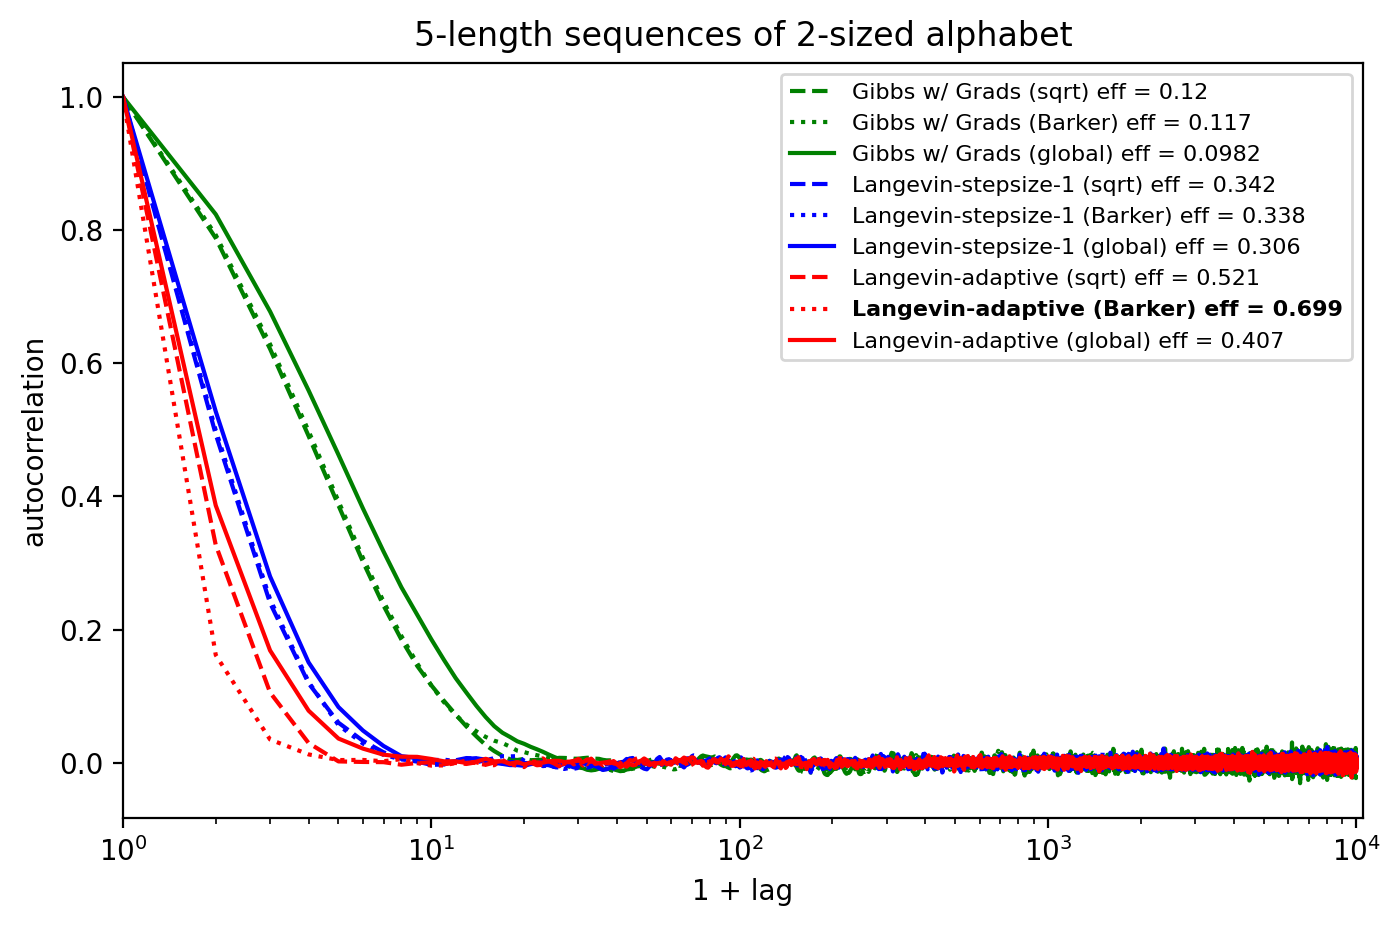

In [26]:
plot_autocorrelation(5, 2)

mean distance = 0.700
mean distance = 0.687
mean distance = 0.490
mean distance = 3.072
mean distance = 3.146
mean distance = 3.305
mean distance = 2.435
mean distance = 3.266
mean distance = 1.647


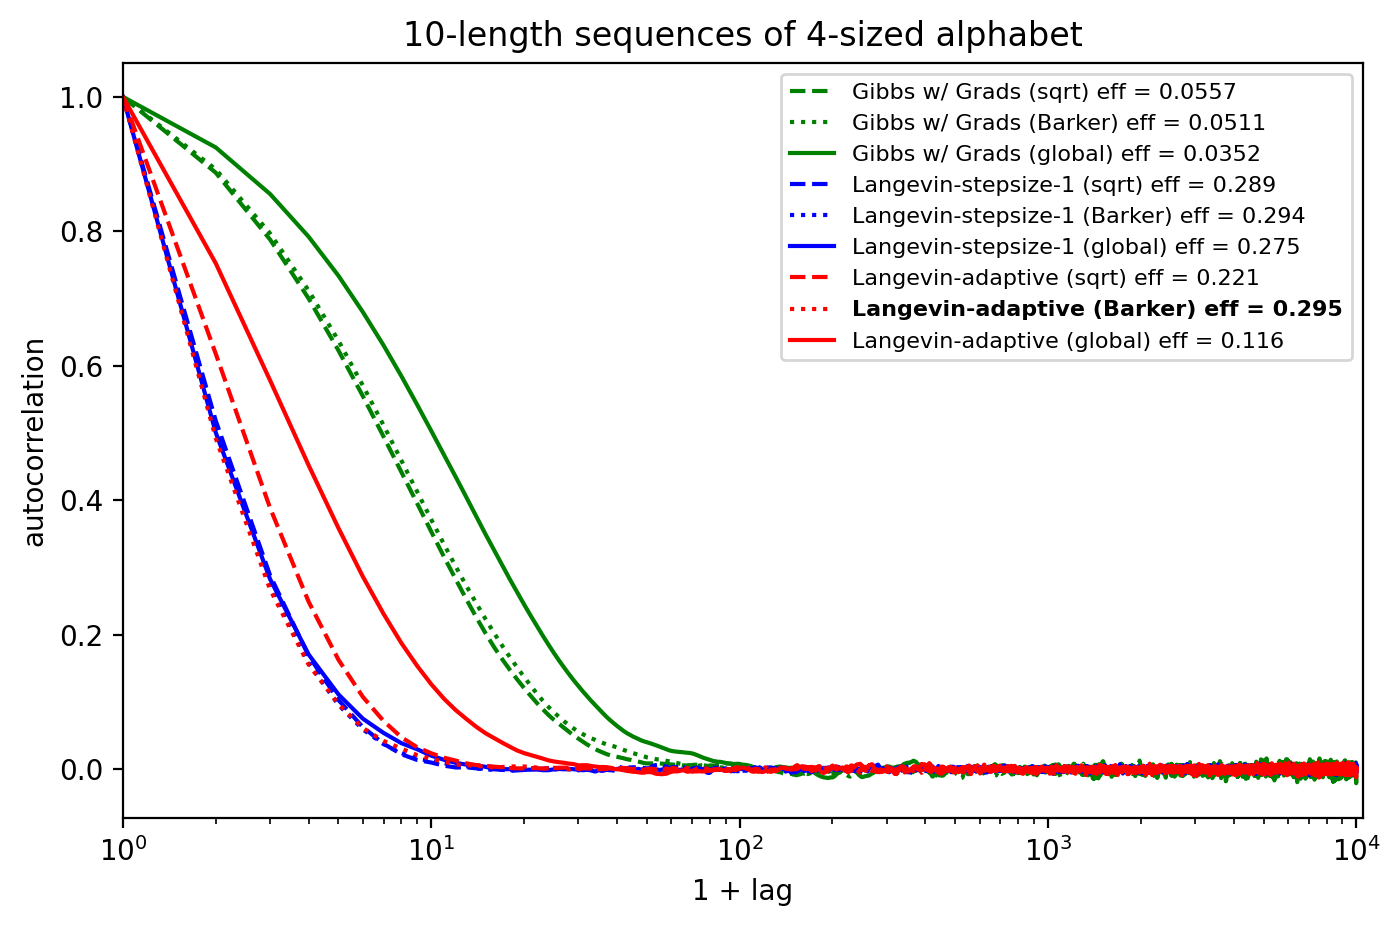

In [27]:
plot_autocorrelation(10, 4)

mean distance = 0.834
mean distance = 0.820
mean distance = 0.524
mean distance = 3.634
mean distance = 3.876
mean distance = 5.972
mean distance = 3.697
mean distance = 4.185
mean distance = 1.781


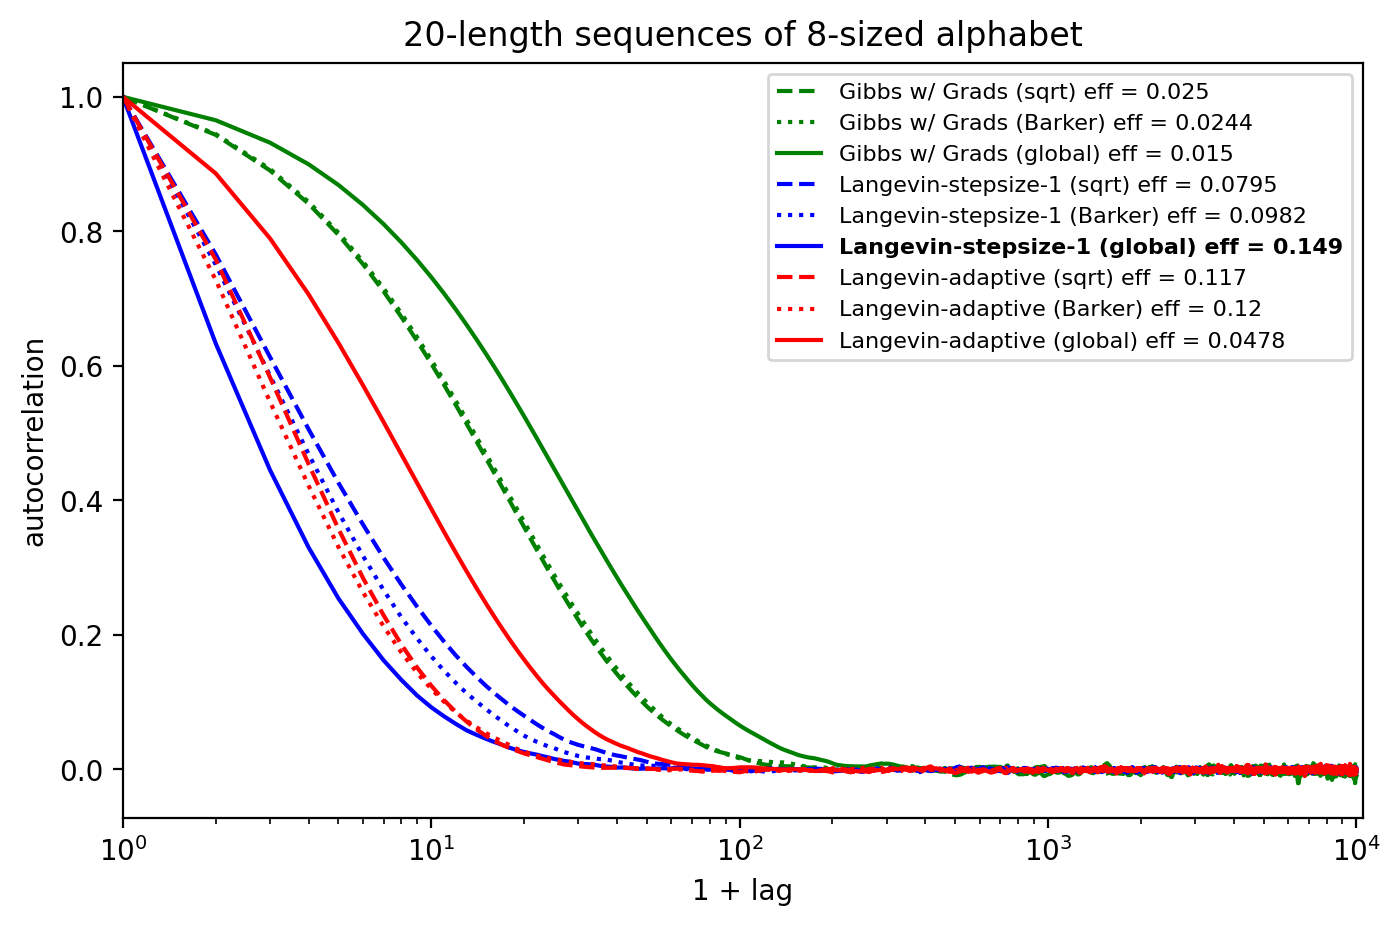

In [28]:
plot_autocorrelation(20, 8)

mean distance = 0.913
mean distance = 0.903
mean distance = 0.423
mean distance = 0.219
mean distance = 0.118
mean distance = 0.938
mean distance = 4.375
mean distance = 3.102
mean distance = 0.877


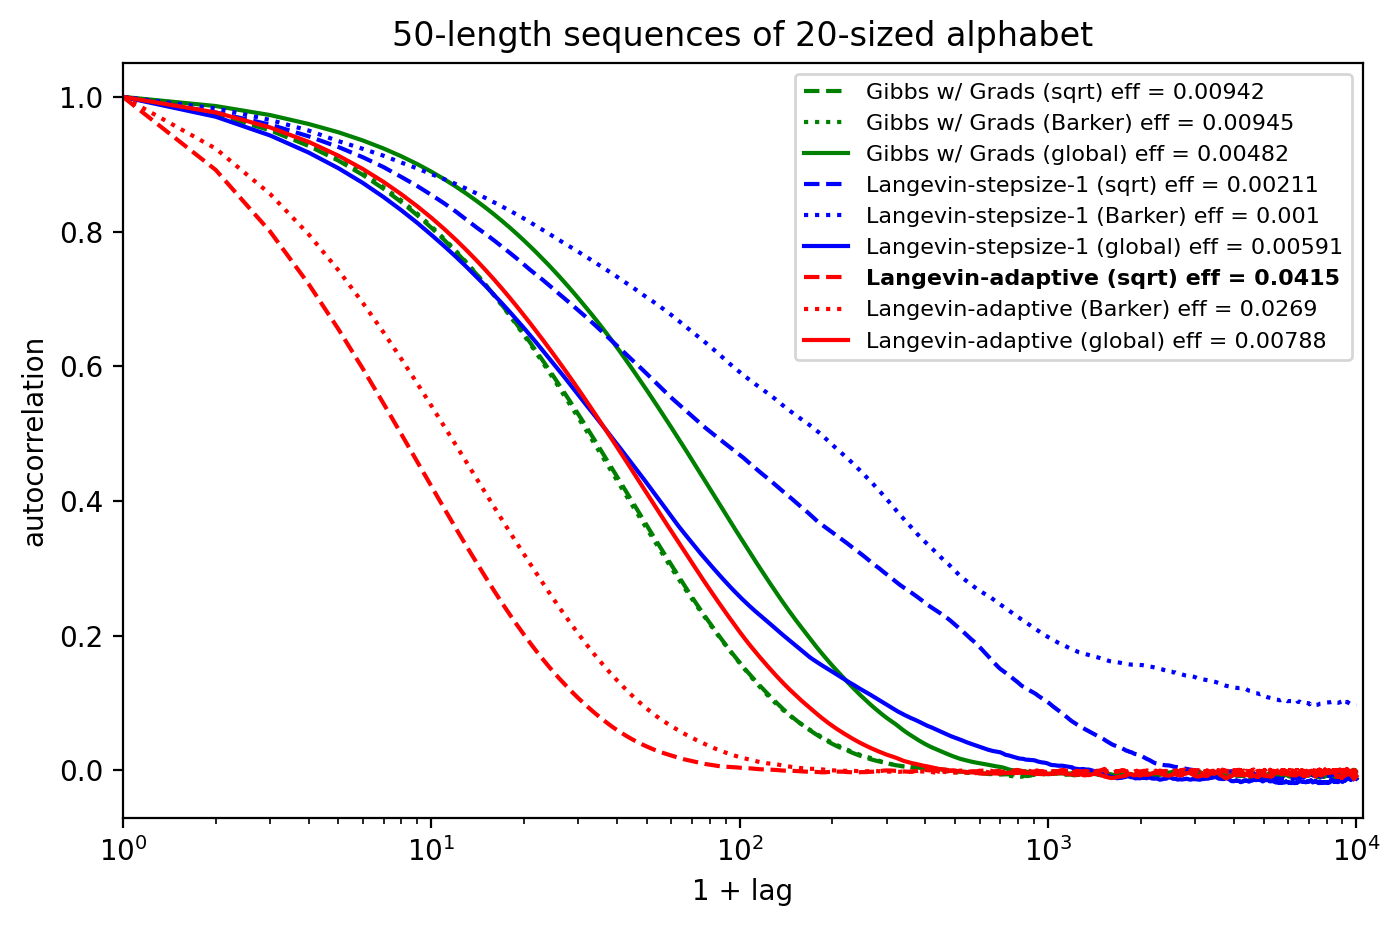

In [29]:
plot_autocorrelation(50, 20)

## Systematic comparison across temperatures

In [30]:
def get_eff(p: int, k: int, g: callable, mcmc: callable, temperature: float, n=10000):
    d = random_potts(p, k, temperature=temperature)
    xs = []
    for i, (x, _) in enumerate(mcmc(d, g=g)):
        xs.append(x)
        if i >= n:
            break
    x = torch.stack(xs)
    a = autocorrelation(x, dim=0).mean([1,2])
    return eff(a)

In [44]:
EFFS = {}  # Memoize so we can resume on error.

def get_effs(ps, ks, gs, mcmcs, temperatures, result=EFFS):
    configs = list(itertools.product(ps, ks, gs, mcmcs, enumerate(temperatures)))
    for p, k, g, mcmc, (seed, temperature) in tqdm(configs):
        key = p, k, g, mcmc, temperature
        if key in result:
            continue
        pyro.set_rng_seed(seed)
        result[key] = get_eff(p, k, g, mcmc, temperature)
    return result

In [45]:
%%time
ps = [32]
ks = [20]
gs = [balance_global, balance_sqrt, balance_barker]
mcmcs = [gibbs_with_gradients, discrete_langevin, adaptive_langevin]
ts = torch.logspace(-1, 1, 20).tolist()
effs = get_effs(ps, ks, gs, mcmcs, ts)

  0%|          | 0/180 [00:00<?, ?it/s]

CPU times: user 12min 9s, sys: 28.1 s, total: 12min 37s
Wall time: 12min 1s


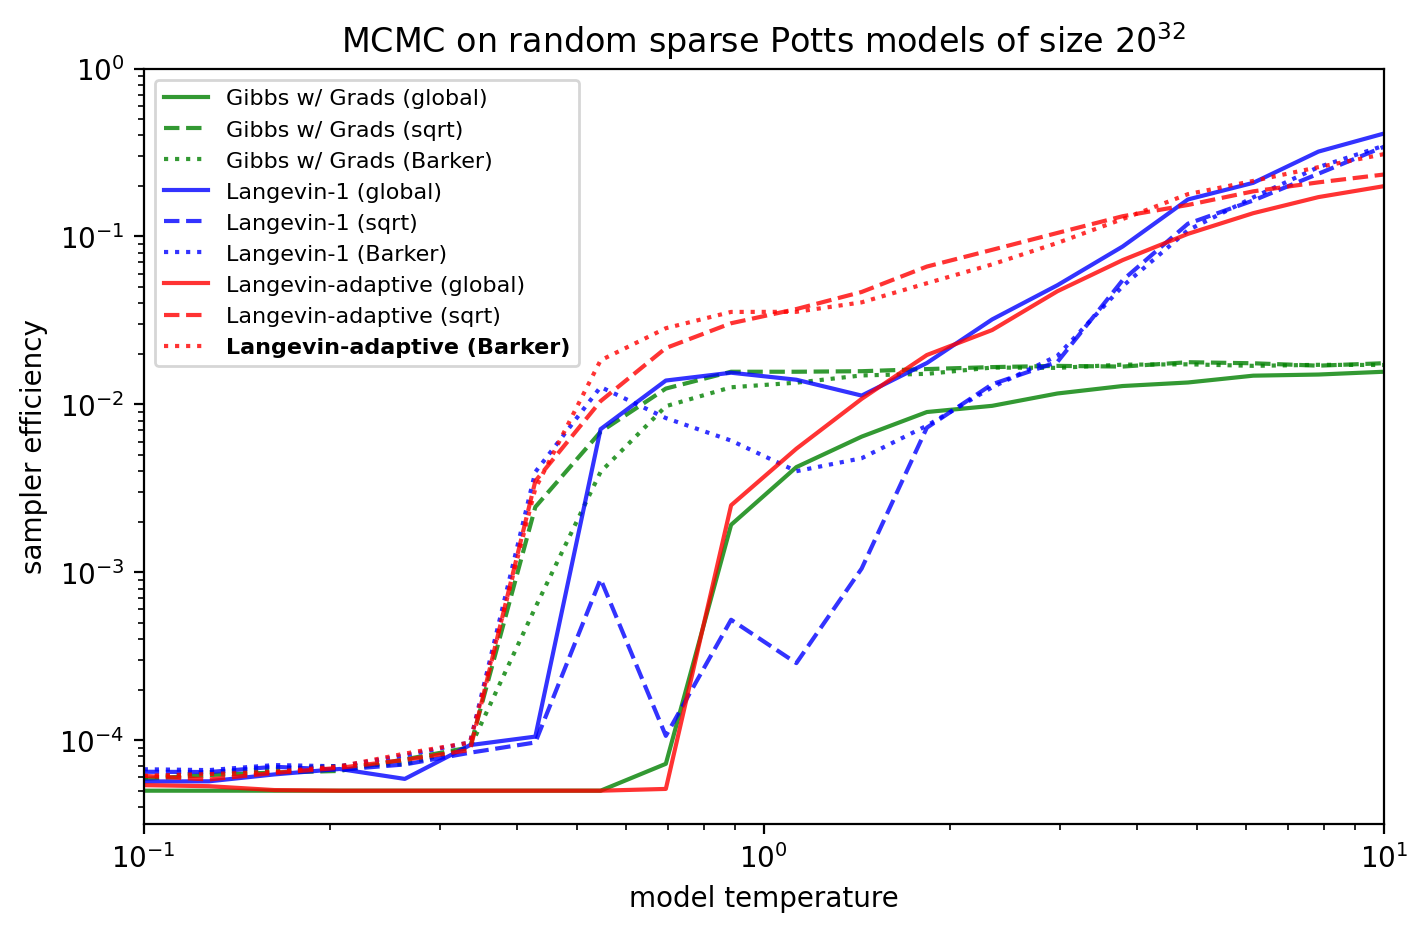

In [52]:
mcmc_styles = {
    gibbs_with_gradients: ("Gibbs w/ Grads", "g"),
    discrete_langevin: ("Langevin-1", "b"),
    adaptive_langevin: ("Langevin-adaptive", "r"),
}
balance_styles = {
    balance_sqrt: ("sqrt", "^", "--"),
    balance_barker: ("Barker", "v", ":"),
    balance_global: ("global", "o", "-"),
}
plt.figure(figsize=(8, 5))
totals = []
for p, k, mcmc, g in itertools.product(ps, ks, mcmcs, gs):
    g_name, marker, linestyle = balance_styles[g]
    mcmc_name, color = mcmc_styles[mcmc]
    label = label=f"{mcmc_name} ({g_name})"
    y = [effs[p, k, g, mcmc, t] for t in ts]
    plt.plot(ts, y, alpha=0.8, color=color, linestyle=linestyle, label=label)
    # plt.scatter(ts, y, alpha=0.8, color=color, marker=marker, label=label)
    totals.append(sum(y))
plt.xscale("log")
plt.yscale("log")
plt.ylim(None, 1)
plt.xlim(0.1, 10)
plt.xlabel("model temperature")
plt.ylabel("sampler efficiency")
plt.title(f"MCMC on random sparse Potts models of size ${ks[0]}^{{{ps[0]}}}$")
legend = plt.legend(loc="best", fontsize=8)
for t, total in zip(legend.get_texts(), totals):
    if total == max(totals):
        t.set_weight("bold")

## Acceptance rate over an annealing schedule

In [53]:
def trace_langevin(
    d: OneHotCategoricalPotts, schedule: Iterable[float]
) -> Dict[str, List[float]]:
    def make_logq(x, nbhd):
        p, k = x.shape
        logq = (nbhd / 2).clamp_(max=20)  # locally balance
        # Set step size so that q(x1[i] = x0[i]) > 1/2 for every i.
        logq += x * logq.exp().sum(-1).max().sub(1).clamp(min=1).log()
        logq -= logq.logsumexp(-1, True)  # normalize
        return logq
        
    # Initialize to random uniform.
    x0 = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    logp0, nbhd0 = d.log_prob_nbhd(x0)

    trace = defaultdict(list)
    for temperature in tqdm(schedule):
        # Propose.
        logq0 = make_logq(x0, nbhd0 / temperature)
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            accept = True
        else:
            # Accept or reject.
            logp1, nbhd1 = d.log_prob_nbhd(x1)
            logq1 = make_logq(x1, nbhd1 / temperature)
            logq01 = torch.tensordot(logq0, x1)
            logq10 = torch.tensordot(logq1, x0)
            ratio = ((logp1 - logp0) / temperature + logq10 - logq01).exp()
            accept = bool(ratio > torch.rand(()))
            if accept:
                x0, logp0, nbhd0 = x1, logp1, nbhd1
        trace["temperature"].append(temperature)
        trace["accept"].append(accept)
        trace["distance"].append(distance)
        trace["logp"].append(float(logp0))

    assert all(len(v) == len(schedule) for v in trace.values())
    trace = {k: torch.tensor(v, dtype=torch.float) for k, v in trace.items()}
    return trace

In [79]:
def plot_trace(p, k, num_steps=1000, t_min=0.1, t_max=10.0):
    pyro.set_rng_seed(20220715)
    d = random_potts(p, k)
    schedule = torch.logspace(math.log10(t_max), math.log(t_min), num_steps).tolist()
    trace = trace_langevin(d, schedule)
    trace["speed"] = trace["distance"] * trace["accept"]

    plt.plot(figsize=(6, 4))
    radius = num_steps // 100
    kernel = torch.ones(radius) / radius
    for _ in range(2):
        kernel = convolve(kernel, kernel, mode="full")
    denom = convolve(torch.ones(num_steps), kernel, mode="same")
    temperature = trace.pop("temperature")
    for label, v in sorted(trace.items()):
        v = convolve(v, kernel, mode="same") / denom
        plt.plot(temperature.numpy(), v.numpy(), label=label, lw=1)
    plt.axhline(1, color="black", lw=1, ls="--", alpha=0.4, zorder=-1)
    plt.axhline(p, color="red", lw=1, ls="--", alpha=0.4, zorder=-1)
    plt.xlim(t_min, t_max)
    plt.ylim(0.1, None)
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="best")
    plt.xlabel("temperature")
    plt.title(f"Annealing a Potts model of size ${k}^{{{p}}}$\n"
              f"logp max = {trace['logp'].max():0.4g}, final = {trace['logp'][-1]:0.4g}")

  0%|          | 0/1000 [00:00<?, ?it/s]

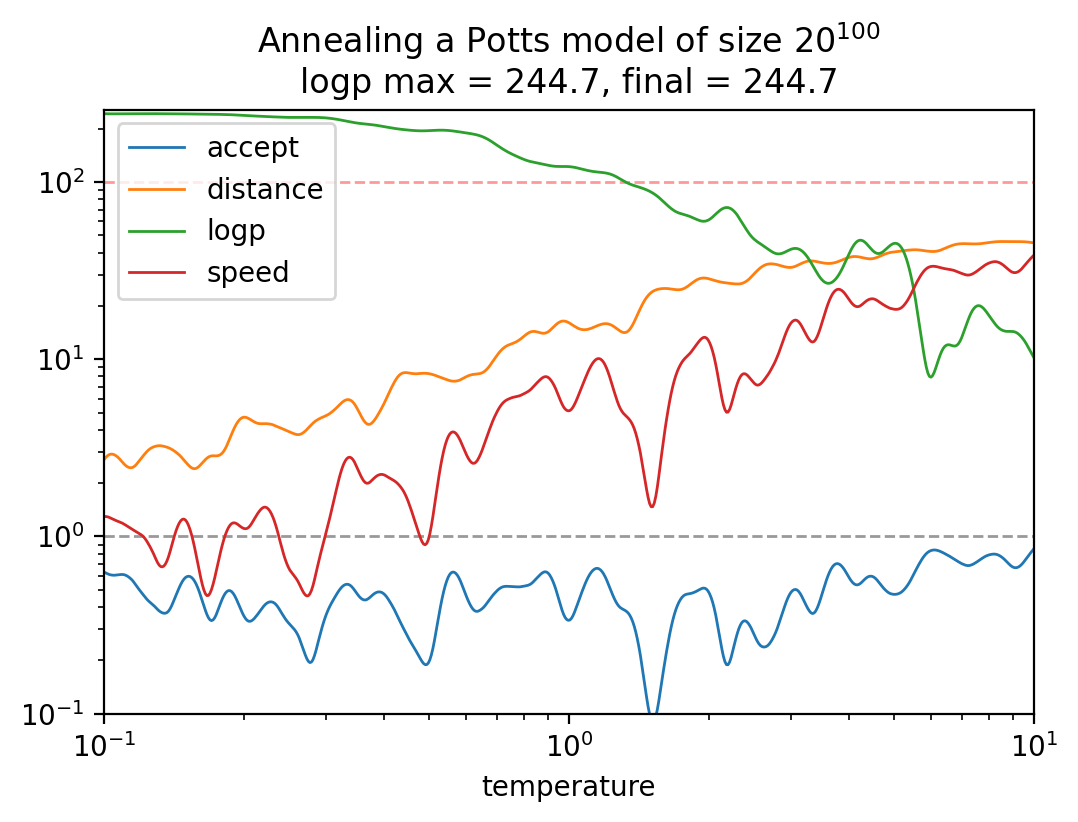

In [80]:
plot_trace(100, 20)

  0%|          | 0/1000 [00:00<?, ?it/s]

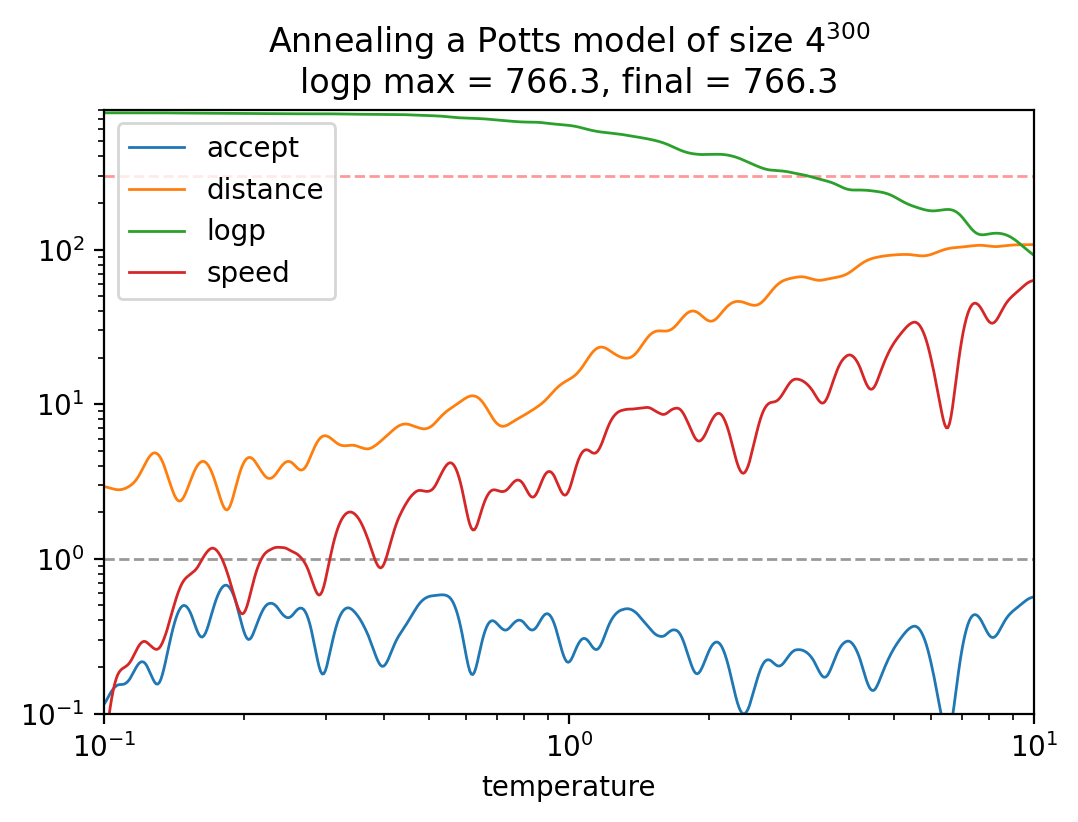

In [81]:
plot_trace(300, 4)